In [9]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from torchvision.datasets.mnist import MNIST
from torchvision.transforms import ToTensor


def gaussian_noise(x, scale=0.8):
    gaussian_data_x = x + np.random.normal(
        loc=0,
        scale=scale,
        size=x.shape
    )
    # normalize 0~1
    gaussian_data_x = np.clip(gaussian_data_x, 0, 1)
    gaussian_data_x = torch.tensor(gaussian_data_x)
    gaussian_data_x = gaussian_data_x.type(torch.FloatTensor)
    return gaussian_data_x

C:\Users\labadmin\AppData\Local\Temp\2\ipykernel_1468\826725982.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gaussian_data_x = torch.tensor(gaussian_data_x)


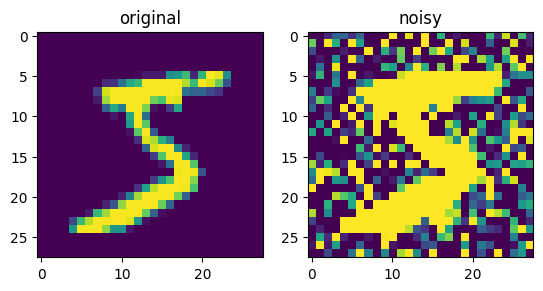

In [10]:
train_data = MNIST(root='./', train=True, download=True, transform=ToTensor())
test_data = MNIST(root='./', train=False, download=True, transform=ToTensor())

img = train_data.data[0]
gaussian = gaussian_noise(img)

plt.subplot(1, 2, 1)
plt.title('original')
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.title('noisy')
plt.imshow(gaussian)
plt.show()

In [11]:
from torch.utils.data.dataset import Dataset


class Denoising(Dataset):
    def __init__(self):
        self.mnist = MNIST(root='./', train=True, download=True, transform=ToTensor())
        self.data = []  # noise data

        for i in range(len(self.mnist)):
            noisy_input = gaussian_noise(self.mnist.data[i])
            input_tensor = torch.tensor(noisy_input)
            self.data.append(torch.unsqueeze(input_tensor, dim=0))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        data = self.data[i]

        label = self.mnist.data[i] / 255

        return data, label

In [12]:
import torch.nn as nn


class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, hidden_dim):
        super(BasicBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, hidden_dim, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(hidden_dim, out_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)

        return x

In [13]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()

        # 입력 채널 = 1, gray_img
        self.conv1 = BasicBlock(in_channels=1, out_channels=16, hidden_dim=16)
        self.conv2 = BasicBlock(in_channels=16, out_channels=8, hidden_dim=8)

        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)

        return x

In [14]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.conv1 = BasicBlock(in_channels=8, out_channels=8, hidden_dim=8)
        self.conv2 = BasicBlock(in_channels=8, out_channels=16, hidden_dim=16)

        self.conv3 = nn.Conv2d(in_channels=16, out_channels=1, kernel_size=3, padding=1)

        self.upsample1 = nn.ConvTranspose2d(8, 8, kernel_size=2, stride=2)
        self.upsample2 = nn.ConvTranspose2d(16, 16, kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.upsample1(x)
        x = self.conv2(x)
        x = self.upsample2(x)
        x = self.conv3(x)

        return x

In [15]:
class CAE(nn.Module):
    def __init__(self):
        super(CAE, self).__init__()

        self.enc = Encoder()
        self.dec = Decoder()

    def forward(self, x):
        x = self.enc(x)
        x = self.dec(x)
        x = torch.squeeze(x)

        return x

In [ ]:
import tqdm

from torch.utils.data.dataloader import DataLoader
from torch.optim.adam import Adam

device = 'cuda' if torch.cuda.is_available() else 'cpu'

trainset = Denoising()
train_loader = DataLoader(trainset, batch_size=32)

model = CAE().to(device)

lr = 0.001
optim = Adam(params=model.parameters(), lr=lr)

for epoch in range(20):
    iterator = tqdm.tqdm(train_loader)
    for data, label in iterator:
        optim.zero_grad()
        pred = model(data.to(device))

        loss = nn.MSELoss()(torch.squeeze(pred), label.to(device))
        loss.backward()
        optim.step()
        iterator.set_description(f'epoch: {epoch+1} loss: {loss.item()}')
torch.save(model.state_dict(), './CAE.pth')

C:\Users\labadmin\AppData\Local\Temp\2\ipykernel_1468\826725982.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gaussian_data_x = torch.tensor(gaussian_data_x)
C:\Users\labadmin\AppData\Local\Temp\2\ipykernel_1468\4057901692.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_tensor = torch.tensor(noisy_input)
epoch: 20 loss: 0.007531760726124048: 100%|██████████| 1875/1875 [00:22<00:00, 81.69it/s] 


C:\Users\labadmin\AppData\Local\Temp\2\ipykernel_1468\826725982.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gaussian_data_x = torch.tensor(gaussian_data_x)


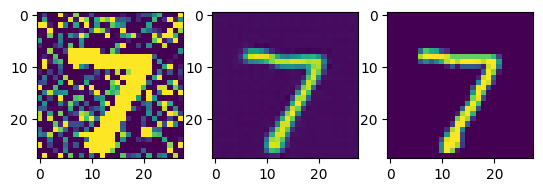

In [17]:
model.cpu()

with torch.no_grad():
    model.load_state_dict(torch.load('./CAE.pth', map_location=device))

    img = test_data.data[0]
    gaussian = gaussian_noise(img)

    input = torch.unsqueeze(gaussian, dim=0)
    input.type(torch.FloatTensor)
    input.to(device)
    input = torch.unsqueeze(input, dim=0)

    plt.subplot(1,3,1)
    plt.imshow(torch.squeeze(gaussian))
    plt.subplot(1,3,2)
    plt.imshow(torch.squeeze(model(input)))
    plt.subplot(1,3,3)
    plt.imshow(torch.squeeze(img))
    plt.show()